In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as P
from astropy.io import fits
from astropy import units as un
from astropy.table import Table
import scipy as S
from scipy import interpolate


First let's load in the BC03 model ASCII files which contain the wavelengths, time steps and fluxes 

In [4]:
#model = str(raw_input('Tell me again the location of the extracted (.ised_ASCII) SPS model to use to predict the u-r and NUV-u colours, e.g. ~/extracted_bc2003_lr_m62_chab_ssp.ised_ASCII :'))
model = '/Users/becky/Projects/Green-Valley-Project/bc03/models/Padova1994/chabrier/ASCII/extracted_bc2003_hr_m62_chab_ssp.ised_ASCII'
data = np.loadtxt(model)
model_ages = data[0,1:]
model_lambda = data[1:,0]
model_fluxes = data[1:,1:]
time = np.arange(0, 0.01, 0.003)
t = np.linspace(0,14.0,100)
time_steps = np.append(time, t[1:])*1E9
#First mask the ages of the very young stars hidden in birth clouds
mask = model_ages[model_ages<4E6]
model_fluxes[:,0:len(mask)] = 0.0
# Calculate the fluxes at the ages specified by the time steps rather than in the models using numpy/scipy array manipulations rather than a for loop
f = interpolate.interp2d(model_ages, model_lambda, model_fluxes)
interp_fluxes_sim = f(time_steps, model_lambda)

Now define our SFH function which can calcualte the SFH for an array of tq and tau values

In [5]:
def expsfh(tq, tau, time):
    """ This function when given an array of [tq, tau] values will calcualte the SFR at all times. First calculate the sSFR at all times as defined by Peng et al. (2010) - then the SFR at the specified time of quenching, tq and set the SFR at this value  at all times before tq. Beyond this time the SFR is an exponentially declining function with timescale tau. 
        
        INPUT:
        :tau:
        The exponential timescale decay rate of the star formation history in Gyr. Allowed range from the rest of the functions is 0 < tau [Gyr] < 5. Shape (1, M, N). 
        
        :tq: 
        The time at which the onset of quenching begins in Gyr. Allowed ranges from the beginning to the end of known cosmic time. Shape (1, M, N). 
        
        e.g:
        
        tqs = np.linspace(0, 14, 10)
        taus = np.linspace(0, 4, 5)
        
        tq = tqs.reshape(1,-1,1).repeat(len(taus), axis=2)
        tau = taus.reshape(1,1,-1).repeat(len(tqs), axis=1)
        
        :time:
        An array of time values at which the SFR is calcualted at each step. Shape (T, 1, 1)
        
        RETURNS:
        :sfr:
        Array of the same dimensions of time containing the sfr at each timestep. Shape (T, M, N). 
        """
    ssfr = 2.5*(((10**10.27)/1E10)**(-0.1))*(time/3.5)**(-2.2)
    c = np.apply_along_axis(lambda a: a.searchsorted(3.0), axis = 0, arr = time)    
    ssfr[:c] = np.interp(3.0, time.flatten(), ssfr.flatten())
    c_sfr = np.interp(tq, time.flatten(), ssfr.flatten())*(1E10)/(1E9)
    ### definition is for 10^10 M_solar galaxies and per gyr - convert to M_solar/year ###
    sfr = np.ones_like(time)*c_sfr
    mask = time <= tq
    sfrs = np.ma.masked_array(sfr, mask=mask)
    times = np.ma.masked_array(time-tq, mask=mask)
    sfh = sfrs*np.exp(-times/taus)
    return sfh.data

Similarly we now need a function which can take the BC03 SSP flux models and calculate them for a composite SSP model with SFH described by the exponential function we defined above. This function needs to work for an array of times and fluxes but only one tq and tau. 

In [6]:
def assign_total_flux_numpy(model_ages, model_lambda, model_fluxes, time_steps, sim_SFR):
        #First mask the ages of the very young stars hidden in birth clouds
    mask = model_ages[model_ages<4E6]
    model_fluxes[:,0:len(mask)] = 0.0
        # Calculate the fluxes at the ages specified by the time steps rather than in the models using numpy/scipy array manipulations rather than a for loop
    #f = interpolate.interp2d(model_ages, model_lambda, model_fluxes)
    #interp_fluxes_sim = f(time_steps, model_lambda)
        # Produce the array to keep track of the ages of the fractional SFR at each time step
    frac_sfr = sim_SFR/sim_SFR[0]
    fraction_array = S.linalg.toeplitz(frac_sfr, np.zeros_like(frac_sfr)).T
        # Produce the array to keep track of the ages of the mass fraction of stars formed at each time step
    m_array = (sim_SFR.T)*(np.append(1, np.diff(time_steps)))
    mass_array = S.linalg.toeplitz(m_array, np.zeros_like(frac_sfr)).T
        # Produce the array to keep track of the fraction of flux produced at each timestep 
    frac_flux_array = fraction_array*mass_array
        # Calculate the total flux contributed by all of the fractions at each time step by summing across all wavelength values
    flux_lambda = frac_flux_array*(np.split(interp_fluxes_sim.T, len(model_lambda), axis=1))
    total_flux = (np.sum(flux_lambda, axis=1)).T # Array of dimensions (len(timesteps), len(model_lambda))
    return total_flux

In [7]:
ti = np.arange(0, 0.01, 0.003)
t = np.linspace(0,14.0,100)
time = np.append(ti, t[1:]).reshape(-1,1,1)
tq = np.linspace(0.1, 14, 50)
tau = np.linspace(0.01, 4, 50)

tqs = tq.reshape(1,-1,1).repeat(len(tau), axis=2)
taus = tau.reshape(1,1,-1).repeat(len(tq), axis=1)

# total_flux_hr = np.empty((time.shape[0], len(data[1:,0]), len(tq), len(tau)))
# sfr = expsfh(tqs, taus, time)
# ### Work out total flux at each time given the sfh model of tau and tq (calls fluxes function) ###
# for n in range(len(tq)):
#     for m in range(len(tau)):    
#         total_flux_hr[:,:,n,m] = assign_total_flux_numpy(data[0,1:], data[1:,0], data[1:,1:], time.flatten()*1E9, sfr[:,n,m])

In [ ]:
#np.save('/Users/becky/Projects/mangaagn/data/bc03_high_res_m62_103_t_50_tq_50_tau.npy', total_flux_hr)

In [8]:
total_flux_hr = np.load('/Users/becky/Projects/mangaagn/data/bc03_high_res_m62_103_t_50_tq_50_tau.npy')

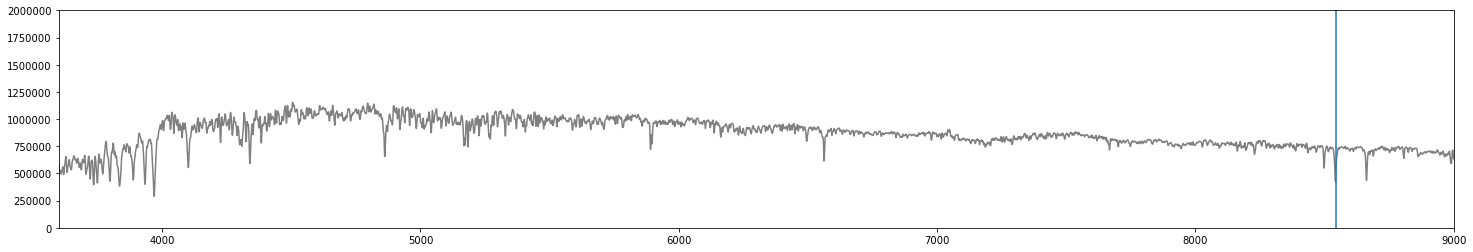

In [239]:
P.figure(figsize=(25,4))
P.plot(data[1:,0],total_flux_hr[-3,:,-5,3], c='gray')
#P.plot(data_lr[1:,0],flux_density[-1,:], c='k')
P.xlim(3600, 9000)
P.ylim(0, 2E6)
P.axvline(8544, 0, np.max(total_flux_hr[40,a:b,-5,3]))
#P.ylim(0, ymax=0.4E-25)
#P.fill_betweenx([0, np.max(total_flux_hr[40,a:b,40,3])], x1=lamem-10, x2=lamem+10, color='r', alpha=0.1)
#P.fill_betweenx([0, 1E-25], x1=4050, x2=4250, color='r', alpha=0.1)
#P.axvline(3750, 0, 5*1e7, c='r')
#P.axvline(3950, 0, 5*1e7, c='r')
#P.axvline(4050, 0, 5*1e7, c='r')
#P.axvline(4250, 0, 5*1e7, c='r')

In [9]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=71.0, Om0 = 0.26)
nsa_z = 0.0263343
ld = cosmo.luminosity_distance(nsa_z)

In [11]:
w = np.repeat(data[1:,0].reshape(1,-1, 1, 1), 103, axis=0)

In [12]:
waves =np.repeat(np.repeat(w, 50, axis=2), 50, axis=3)

In [14]:
np.save('/Users/becky/Projects/mangaagn/data/lambda_bc03_high_res_m62_103_t_50_tq_50_tau.npy', waves)

In [240]:
a = np.searchsorted(data[1:,0], [8444])[0]
b = np.searchsorted(data[1:,0], [8644])[0]
lamem = 8544

In [241]:
hamask = np.logical_or(waves[:,a:b,:,:]<lamem-10, waves[:,a:b,:,:]>lamem+10)
hacmask = np.logical_and(waves[:,a:b,:,:] >lamem-10, waves[:,a:b,:,:]<lamem+10)

In [242]:
fs = np.ma.masked_array(total_flux_hr[:,a:b,:,:], mask=hamask)
fsc = np.ma.masked_array(total_flux_hr[:,a:b,:,:], mask=hacmask)

In [243]:
I = np.mean(fsc, axis=1).reshape(103,1,50,50)

In [244]:
W = np.trapz(-(fs-I)/I, data[1:,0][a:b], dx=np.diff(data[1:,0][a:b]), axis=1)

In [125]:
W.shape

(103, 50, 50)

In [245]:
np.save('/Users/becky/Projects/mangaagn/data/caii8544_bc03_high_res_m62_103_t_50_tq_50_tau.npy', W.data)

In [202]:
ha = np.load('/Users/becky/Projects/mangaagn/data/halpha_bc03_high_res_m62_103_t_50_tq_50_tau.npy')

In [193]:
hd = np.load('/Users/becky/Projects/mangaagn/data/hdelta_bc03_high_res_m62_103_t_50_tq_50_tau.npy')

In [105]:
from IPython.html.widgets import interact

In [249]:
def browse_images(hdelta, halpha, time):
    n = halpha.shape[0]
    def view_image(i):
        P.figure(figsize=(12, 5))
        ax = P.subplot(121)
        ha = ax.imshow(halpha[i-1,:,:].T, cmap=P.cm.spectral_r, interpolation='none', aspect='auto', origin='lower', extent=(0, 14, 0, 4))
        cb = P.colorbar(ha)
        cb.set_label(r'$\rm{EW}[\rm{H}\delta]$', fontsize=14)
        ax.set_title(r'$time = $ %.5g $\rm{Gyr}$' % time.flatten()[i-1], fontsize=14)
        ax = P.subplot(122)
        hd = ax.imshow(hdelta[i-1,:,:].T, cmap=P.cm.spectral_r, interpolation='nearest', aspect='auto', origin='lower', extent=(0, 14, 0, 4))
        cb = P.colorbar(hd)
        cb.set_label(r'$\rm{EW}[\rm{CaII}]$', fontsize=14)
        ax.set_title(r'$time = $ %.5g $\rm{Gyr}$' % time.flatten()[i-1], fontsize=14)
        P.show()
    interact(view_image, i=(1,n))

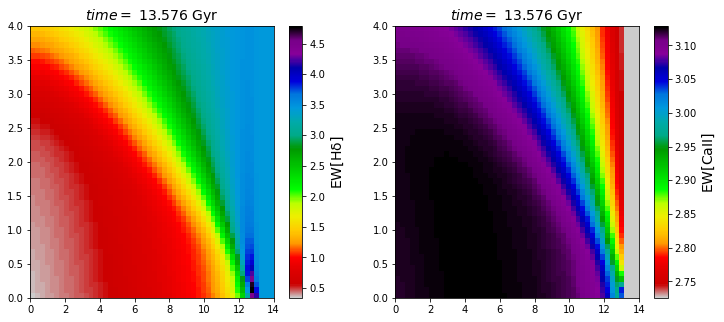

In [250]:
browse_images(W, hd, time)

In [253]:
from astropy.io import fits

In [257]:
ifu = fits.open('/Users/becky/Projects/mangaagn/data/manga-8480-3701-LOGCUBE-SPX-GAU-MILESHC.fits')

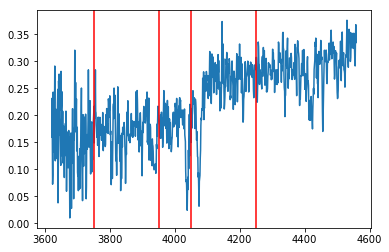

In [280]:
P.plot(ifu[4].data[0:1000], ifu[1].data[0:1000,22, 22])
P.axvline(3750, 0, 5*1e7, c='r')
P.axvline(3950, 0, 5*1e7, c='r')
P.axvline(4050, 0, 5*1e7, c='r')
P.axvline(4250, 0, 5*1e7, c='r')

In [288]:
map =fits.open('/Users/becky/Projects/mangaagn/data/manga-8480-3701-MAPS-SPX-GAU-MILESHC.fits')

In [313]:
radius = map[2].data[0]
rad_bins = np.array([0, 2.5, 5, 7.5, 10, 12.5, 15])

In [314]:
from scipy.stats import binned_statistic as bs

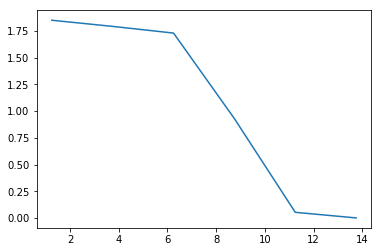

In [322]:
P.plot(rad_bins[:-1]+np.diff(rad_bins)/2., bs(radius.flatten(), map[40].data[0].flatten(), statistic='mean', bins=rad_bins)[0])

In [325]:
bs(radius.flatten(), map[40].data[0].flatten(), statistic='mean', bins=rad_bins)[1]

array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ])

In [361]:
a = np.array([np.where(radius < i) for i in bs(radius.flatten(), map[40].data[0].flatten(), statistic='mean', bins=rad_bins)[1]])

In [364]:
a[:,0]

7

In [389]:
bind4000 = np.ones_like(radius)
for i in range(len(rad_bins)-1):
    bind4000[np.where(np.logical_and(radius > rad_bins[i], radius<rad_bins[i+1]))] = bs(radius.flatten(), map[40].data[0].flatten(), statistic='mean', bins=rad_bins)[0][i]

#[bind4000[a[:,0][i], a[:,1][i]] = bs(radius.flatten(), map[40].data[0].flatten(), statistic='mean', bins=rad_bins)[0][i] for i in np.arange(a.shape[0])-1]

In [390]:
np.max(bind4000)

1.8504620673057353

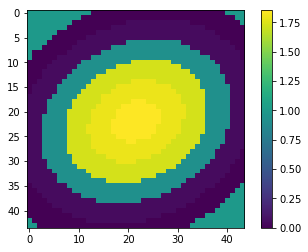

In [391]:
P.imshow(bind4000)
P.colorbar()

Now let's calculate D4000, for this we need to convert the BC03 luminosity output (Lsol/AA) to erg/s/cm^2/Hz. So we not only need to use the fluxes to convert the unit, but also to multiply by the lumninosity distance of the galaxy we will be comparing the D4000 values with. We then need to calcualte the ratio of the averge flux densities between 3750-3950AA and 4050-4250AA

In [48]:
c = 299792.458 * (un.km/un.s)

In [59]:
np.searchsorted(data[1:,0], [3745, 4255])

array([ 770, 1280])

In [60]:
f = c/(waves[:,770:1280,:,:]*un.AA).to(un.km)

In [61]:
tf = total_flux_hr[:,770:1280,:,:]*(un.solLum/un.AA)

In [62]:
flux_density = ((tf.to(un.erg/(un.s*un.AA)))*(data[1:,0][770:1280].reshape(1,-1,1,1)*un.AA)/f.to(un.Hz))/(4*np.pi*(ld.to(un.cm)**2))

In [66]:
mask1 = (np.logical_or(waves[:,770:1280]<3750, waves[:,770:1280]>3950))
mask2 = (np.logical_or(waves[:,770:1280]<4050, waves[:,770:1280]>4250))

In [68]:
flux_ds1 = np.ma.masked_array(flux_density, mask=mask1)
flux_ds2 = np.ma.masked_array(flux_density, mask=mask2)

In [69]:
upper = np.mean(flux_ds1, axis=1)
lower = np.mean(flux_ds2, axis=1)

In [70]:
def browse_images(fd, time):
    n = fd.shape[0]
    def view_image(i):
        P.figure(figsize=(5, 5))
        ax = P.subplot(111)
        ur = ax.imshow(fd[i-1,:,:].T, cmap=P.cm.spectral, interpolation='nearest', aspect='auto', origin='lower', extent=(0, 14, 0, 4))
        cb = P.colorbar(ur)
        cb.set_label(r'$\rm{D4000}$', fontsize=14)
        ax.set_title(r'$time = $ %.5g $\rm{Gyr}$' % time.flatten()[i-1], fontsize=14)
        P.show()
    interact(view_image, i=(1,n))

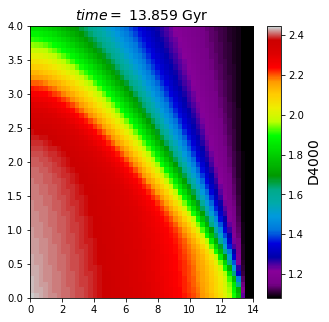

In [71]:
browse_images(lower/upper, time)

In [87]:
np.save('/Users/becky/Projects/mangaagn/data/D4000_bc03_high_res_m62_103_t_50_tq_50_tau.npy', (lower/upper).data.value)